### Analyses spread of BirdNET scores over 0.99 across clusters

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


**1 Add BirdNET scores to the sample dataframe**

In [2]:
# load dataframe for noise cluster
sample3 = pd.read_csv("nepalbirds2021_sample3_even_clustered.csv")
sample3.head()
sample3.shape

(96807, 1035)

In [3]:
# adapt dataframe to exclude embeddings
sample3red = sample3[['path', 'start_time', 'end_time', 'year', 'recorded_on', 'site', 'regime', 'min', 'max', 'cluster']]
#sample3red.head()

In [4]:
# read in detections
detections = pd.read_parquet("data/nepal/birdnet_detections/nepalbirds_detections_merged.parquet")
#detections.head()

In [5]:
# merge on path and start_time
sample3scored = sample3red.merge(
    detections,
    on=['path', 'start_time'],
    how='left')
sample3scored = sample3scored[sample3scored['cluster'] != -1]
sample3scored.head()

,path,start_time,end_time_x,year,recorded_on,site,regime,min,max,cluster,end_time_y,species,score
6,downloads/BZ/BZ05/PAM/2021/BZ05_20210330_14000...,18.0,21.0,2021,2021-03-30 14:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,192,NaN,NaN,NaN
7,downloads/BZ/BZ05/PAM/2021/BZ05_20210330_14000...,21.0,24.0,2021,2021-03-30 14:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,192,NaN,NaN,NaN
62,downloads/BZ/BZ05/PAM/2021/BZ05_20210330_20000...,6.0,9.0,2021,2021-03-30 20:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,195,NaN,NaN,NaN
86,downloads/BZ/BZ05/PAM/2021/BZ05_20210331_00000...,0.0,3.0,2021,2021-03-31 00:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,66,NaN,NaN,NaN
87,downloads/BZ/BZ05/PAM/2021/BZ05_20210331_00000...,3.0,6.0,2021,2021-03-31 00:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,66,NaN,NaN,NaN


In [6]:
# filter to only detections of 0.8 or above
sample3score80 = sample3scored[sample3scored['score']>=0.8]
sample3score80.head()


,path,start_time,end_time_x,year,recorded_on,site,regime,min,max,cluster,end_time_y,species,score
262,downloads/BZ/BZ05/PAM/2021/BZ05_20210331_16000...,48.0,51.0,2021,2021-03-31 16:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,145,51.0,Orthotomus sutorius,0.800592
414,downloads/BZ/BZ05/PAM/2021/BZ05_20210401_08000...,24.0,27.0,2021,2021-04-01 08:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,145,27.0,Orthotomus sutorius,0.882498
444,downloads/BZ/BZ05/PAM/2021/BZ05_20210401_10000...,54.0,57.0,2021,2021-04-01 10:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,145,57.0,Arachnothera longirostra,0.958466
445,downloads/BZ/BZ05/PAM/2021/BZ05_20210401_10000...,57.0,60.0,2021,2021-04-01 10:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,145,60.0,Arachnothera longirostra,0.983264
462,downloads/BZ/BZ05/PAM/2021/BZ05_20210401_12000...,48.0,51.0,2021,2021-04-01 12:00:00,BZ05,BZ,2021-03-30 12:15:00,2021-04-24 14:00:00,145,51.0,Tarsiger johnstoniae,0.935423


In [7]:
sample3score80.shape

(3016, 13)

In [8]:
#count occurences per species
species_counts = sample3score80['species'].value_counts()
print(species_counts.head(40))

species
Otus sunia                   1010
Caprimulgus macrurus          805
Hierococcyx varius            407
Caprimulgus affinis            87
Psittacula cyanocephala        84
Ninox scutulata                71
Oriolus xanthornus             60
Prinia socialis                47
Francolinus francolinus        42
Merops philippinus             39
Cinnyris asiaticus             34
Gymnoris xanthocollis          25
Dendrocitta vagabunda          22
Phylloscopus trochiloides      22
Halcyon smyrnensis             21
Prinia hodgsonii               18
Psiloscops flammeolus          15
Prinia inornata                15
Cuculus micropterus            14
Saxicola caprata               14
Gallus gallus                  12
Psilopogon zeylanicus          12
Argya earlei                    9
Parus cinereus                  9
Zosterops palpebrosus           8
Glaucidium radiatum             8
Copsychus fulicatus             7
Psittacula eupatria             6
Crypturellus noctivagus         6
Myioth

**2. Sample: 10 random species withat least 30 birdnet scores over 0.95 each**

In [9]:
# take sample of 10 species x 30 embeddings

random.seed(42)

# count species
species_counts = sample3score80['species'].value_counts()

# filter species with at least 30 occurrences 
eligible_species = species_counts[species_counts >= 30].index.tolist()

# select random 10 species 
random_species = random.sample(eligible_species, 10)

# filter and sample 30 rows per species and combine into final df
dfs = []
for sp in random_species:
    sp_subset = sample3score80[sample3score80['species'] == sp].sample(n=30, random_state=42)
    dfs.append(sp_subset)
sample3score80_subset = pd.concat(dfs).reset_index(drop=True)

# show head
sample3score80_subset.head()

,path,start_time,end_time_x,year,recorded_on,site,regime,min,max,cluster,end_time_y,species,score
0,downloads/NP/NP42/PAM/2021/NP42_20210410_08000...,45.0,48.0,2021,2021-04-10 08:00:00,NP42,NP,2021-04-08 15:00:00,2021-04-30 21:00:00,187,48.0,Cinnyris asiaticus,0.819006
1,downloads/NP/NP48/PAM/2021/NP48_20210413_08000...,21.0,24.0,2021,2021-04-13 08:00:00,NP48,NP,2021-04-09 12:30:00,2021-05-02 00:15:00,187,24.0,Cinnyris asiaticus,0.877972
2,downloads/NP/NP50/PAM/2021/NP50_20210411_10000...,42.0,45.0,2021,2021-04-11 10:00:00,NP50,NP,2021-04-09 16:45:17,2021-05-01 00:15:01,187,45.0,Cinnyris asiaticus,0.892393
3,downloads/NP/NP50/PAM/2021/NP50_20210410_14000...,45.0,48.0,2021,2021-04-10 14:00:00,NP50,NP,2021-04-09 16:45:17,2021-05-01 00:15:01,187,48.0,Cinnyris asiaticus,0.832778
4,downloads/BZ/BZ40/PAM/2021/BZ40_20210501_08000...,45.0,48.0,2021,2021-05-01 08:00:00,BZ40,BZ,2021-04-24 12:15:00,2021-05-03 16:45:00,187,48.0,Cinnyris asiaticus,0.884419


In [10]:
sample3score80_subset.shape

(300, 13)

In [11]:
# export to CSV
sample3score80_subset.to_csv('nepalbirds2_sample3score80_subset.csv', index=False)
print("done")

done


**3. Show cluster spread by species**

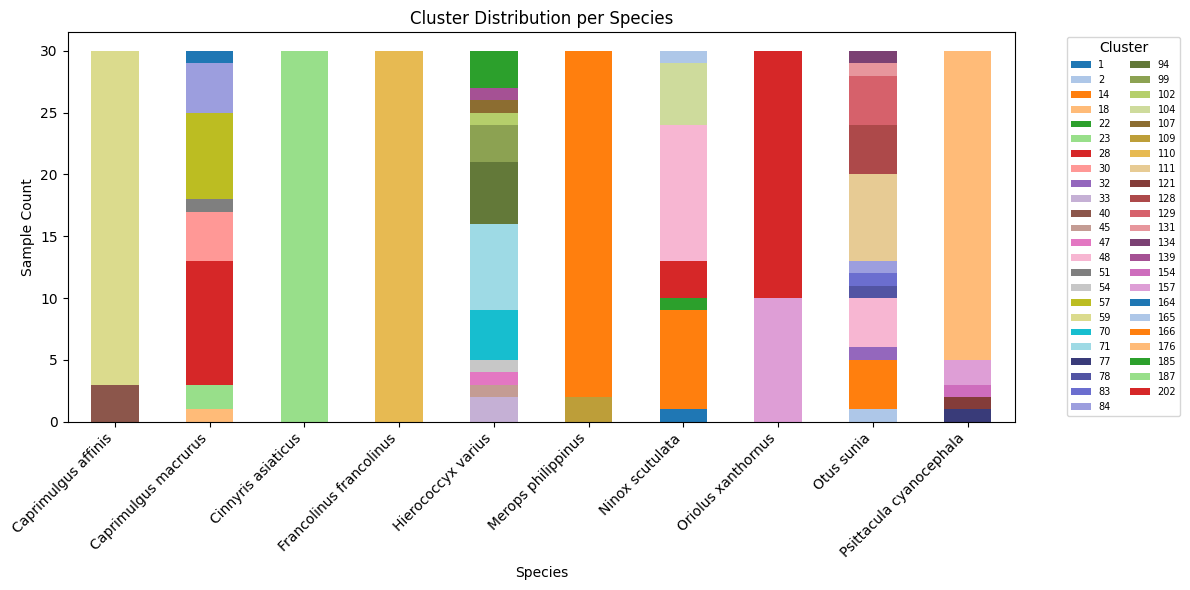

In [12]:
import colorcet as cc

# count samples per species-cluster pair
cluster_counts = sample3score80_subset.groupby(['species', 'cluster']).size().unstack(fill_value=0)

# create colour palette
colors20 = plt.cm.tab20.colors
colors40 = list(colors20) + list(plt.cm.tab20b.colors)

# plot
cluster_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=colors40)
plt.title('Cluster Distribution per Species')
plt.xlabel('Species')
plt.ylabel('Sample Count')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize = 7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
# make labels into arrays
species_labels = sample3score80['species']
cluster_labels = sample3score80['cluster']

# ari and ami scores
ari = adjusted_rand_score(species_labels, cluster_labels)
ami = adjusted_mutual_info_score(species_labels, cluster_labels)

print(f"ARI: {ari:.3f}")
print(f"AMI: {ami:.3f}")

ARI: 0.161
AMI: 0.552


**4. Show % of each specie in each cluster**

In [14]:
# build dataframe
df_cluster_species = pd.DataFrame({
    "cluster": sample3score80["cluster"],
    "species": sample3score80["species"]
})

# count species occurrences per cluster
cluster_species_counts = df_cluster_species.groupby(["cluster", "species"]).size().unstack(fill_value=0)

# compute total count per cluster
cluster_counts = cluster_species_counts.sum(axis=1)

# convert counts to percentages
cluster_species_percent = cluster_species_counts.div(cluster_counts, axis=0) * 100
cluster_species_percent = cluster_species_percent.round(1).sort_index(axis=1)

# add count column
cluster_species_percent["count"] = cluster_counts

# identify dominant species and its percentage
species_percent_only = cluster_species_percent.drop(columns="count")
dominant_species = species_percent_only.idxmax(axis=1)
dominant_percent = species_percent_only.max(axis=1)

# build table
dominant_summary = pd.DataFrame({
    "Dominant Species": dominant_species,
    "Percentage": dominant_percent.round(1),
    "Count": cluster_species_percent["count"]
})

# display scrollable table
from IPython.display import HTML, display

scrollable_html = dominant_summary.style.set_table_attributes(
    'style="display:inline-block;overflow-x:auto;max-width:1000px;"'
).set_caption("Highest percentage contribution of a species per cluster")

display(HTML(scrollable_html.to_html()))

,Dominant Species,Percentage,Count
cluster,,,
0,Ninox japonica,100.000000,1
1,Otus sunia,97.500000,40
2,Otus sunia,100.000000,2
4,Caprimulgus macrurus,100.000000,1
7,Otus sunia,100.000000,10
14,Otus sunia,76.400000,72
15,Prinia hodgsonii,100.000000,1
16,Otus sunia,100.000000,10
17,Hierococcyx varius,80.000000,5


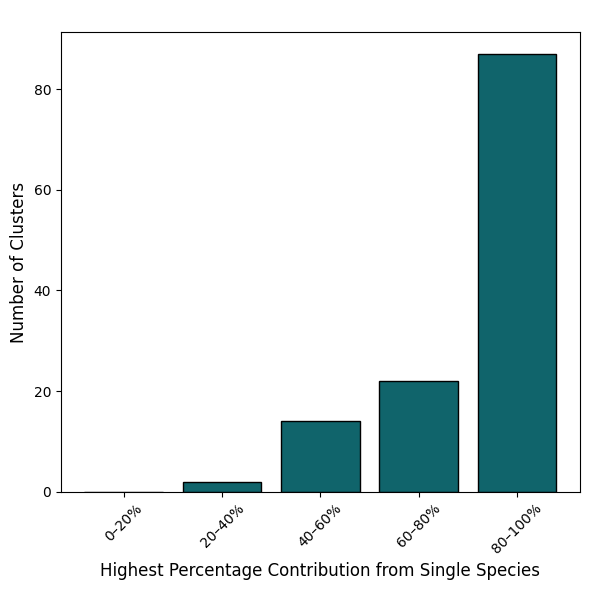

In [15]:
# plot histo of number of clusters per percentage band

# take percentage column from table
dominant_percentages = dominant_summary["Percentage"]

# set bins and structure of histo
bins = range(0, 120, 20)  # 0 to 100 in steps of 10
bin_labels = [f"{i}–{i+20}%" for i in bins[:-1]]
hist = pd.cut(dominant_percentages, bins=bins, labels=bin_labels, include_lowest=True)
bin_counts = hist.value_counts().sort_index()

# plot histo
plt.figure(figsize=(6, 6))
plt.bar(bin_counts.index, bin_counts.values, color="#10646b", edgecolor="black")
plt.xticks(rotation=45)
plt.xlabel("Highest Percentage Contribution from Single Species", fontsize=12)
plt.ylabel("Number of Clusters", fontsize=12)
plt.title("   ")
plt.tight_layout()
plt.savefig("cluster_distributions_of_detections_2.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
import pandas as pd

# Step: Convert histogram data to table
bin_table = pd.DataFrame({
    "Percentage Band": bin_counts.index,
    "Number of Clusters": bin_counts.values
})

# Display table
bin_table

,Percentage Band,Number of Clusters
0,0–20%,0
1,20–40%,2
2,40–60%,14
3,60–80%,22
4,80–100%,87



### Show percentage spread of top three clusters

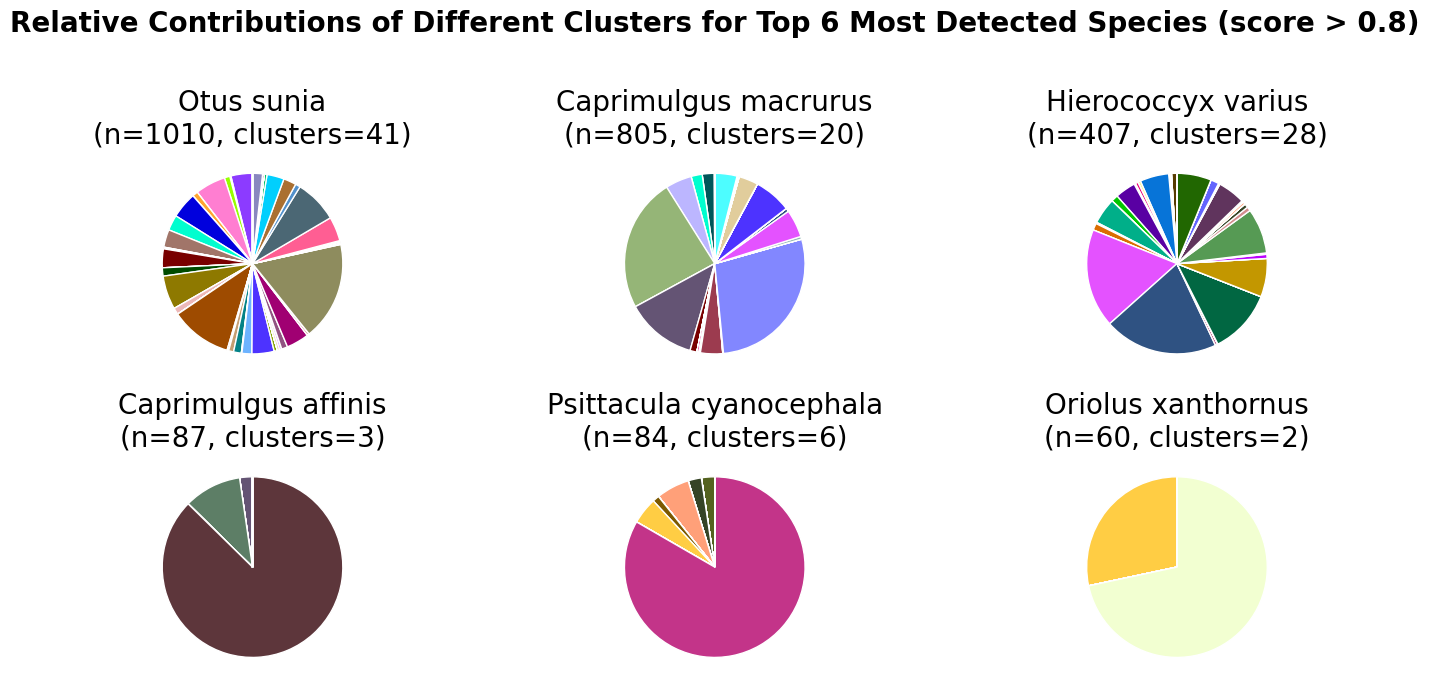

In [17]:
# count samples per species-cluster pair
cluster_counts_all = sample3score80.groupby(['species', 'cluster']).size().unstack(fill_value=0)

# top 6 species
species_list = ['Otus sunia', 'Caprimulgus macrurus', 'Hierococcyx varius','Caprimulgus affinis','Psittacula cyanocephala','Oriolus xanthornus']

# colour palette
colors = cc.glasbey

# plot pie charts
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for ax, species in zip(axes, species_list):
    if species in cluster_counts_all.index:
        counts = cluster_counts_all.loc[species]
        percent = counts / counts.sum() * 100
        total = counts.sum()
        unique_clusters = (counts > 0).sum()

        ax.pie(
            percent,
            labels=None,
            autopct=None,
            startangle=90,
            colors=colors[:len(percent)],
            wedgeprops={'edgecolor': 'white'}
        )
        ax.set_title(f'{species}\n(n={total}, clusters={unique_clusters})', fontsize=20)
    else:
        ax.text(
            0.5, 0.5,
            f'{species} not found',
            ha='center', va='center',
            fontsize=14
        )
        ax.axis('off')
fig.subplots_adjust(wspace=0.3, hspace=0.4)
fig.suptitle(
    "Relative Contributions of Different Clusters for Top 6 Most Detected Species (score > 0.8)",
    fontsize=20,
    weight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for 
plt.savefig("cluster_distributions_of_detections.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
# plot the three random spectrograms for otis sunia

### Check Spectrograms of top 3 species:

In [19]:
# new table with score limited to 0.95 or above: 
sample3score90 = sample3scored[sample3scored['score']>=0.9]
sample3score90.shape

(2115, 13)

In [20]:
# count samples per species–cluster pair
cluster_counts_all = sample3score90.groupby(['species', 'cluster']).size().unstack(fill_value=0)

# pick the top 10 species by total detections
top_species = cluster_counts_all.sum(axis=1).nlargest(3).index

# loop over species and create top 10 clusters tables for each
species_tables = {}

for sp in top_species:
    counts = cluster_counts_all.loc[sp].sort_values(ascending=False)
    top_clusters = counts.head(10).index 

    table_counts = counts.loc[top_clusters].to_frame(name="count")
    table_percent = (table_counts / table_counts.sum() * 100).rename(columns={"count": "percent"})

    # Merge into one dataframe (counts + percents side by side)
    table = table_counts.join(table_percent)
    species_tables[sp] = table

    # print
    print(f"\n {sp} ")
    display(table.round(1))


 Otus sunia 


,count,percent
cluster,,
111,160,27.4
48,95,16.3
37,60,10.3
129,55,9.4
14,45,7.7
22,44,7.5
128,36,6.2
25,30,5.1
1,29,5.0



 Caprimulgus macrurus 


,count,percent
cluster,,
57,172,28.5
28,163,27.0
30,77,12.7
84,50,8.3
70,32,5.3
51,27,4.5
164,26,4.3
27,26,4.3
100,19,3.1



 Hierococcyx varius 


,count,percent
cluster,,
71,72,29.3
70,44,17.9
94,32,13.0
99,21,8.5
107,20,8.1
139,15,6.1
185,13,5.3
45,12,4.9
54,9,3.7


/tmp/ipykernel_3994445/2428562636.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(full_path, sr=None)
/home/jupyter-tommills/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


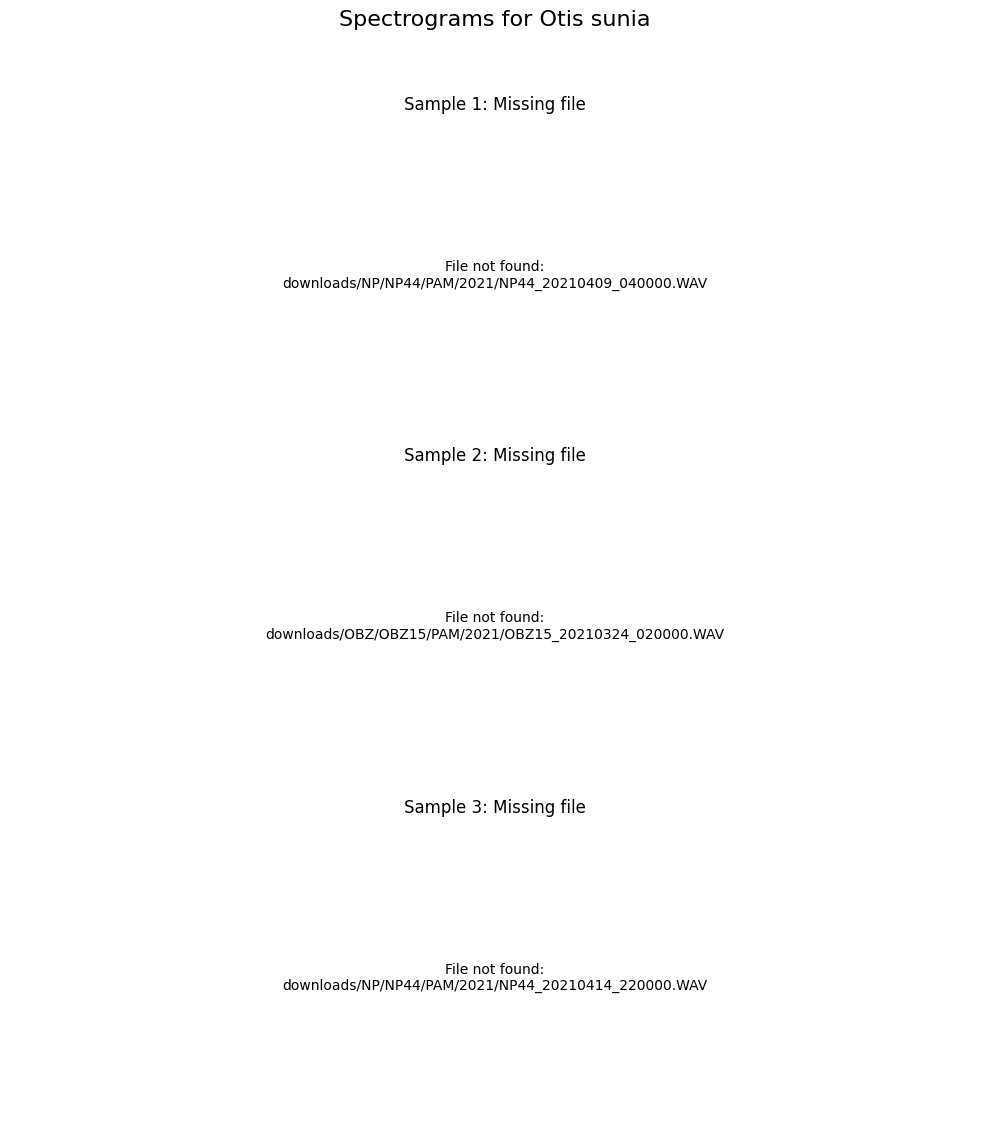

In [21]:
# needs species added
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Filter for Otis sunia
otis_df = sample3score80[sample3score80['species'] == 'Otus sunia']

# Sample 3 random detections
sampled = otis_df.sample(n=3, random_state=42)

# Base audio folder
base_audio_path = 'Nepal_Birds_TM/data/nepalbirds2_allsample3/audio'

# Plot setup
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Spectrograms for Otis sunia', fontsize=16)

# Loop through samples
for i, (idx, row) in enumerate(sampled.iterrows()):
    full_path = os.path.join(base_audio_path, row['path'])
    
    try:
        y, sr = librosa.load(full_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        librosa.display.specshow(S_dB, sr=sr, ax=axes[i], x_axis='time', y_axis='mel')
        axes[i].set_title(f"Sample {i+1}: {row['path']}")
        axes[i].label_outer()
    except FileNotFoundError:
        axes[i].text(0.5, 0.5, f"File not found:\n{row['path']}", ha='center', va='center')
        axes[i].set_title(f"Sample {i+1}: Missing file")
        axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()